# Reddit Sarcasm EDA pt 2

### Sveto Givaty

#### 11/10/2023

----------------------------------------------------------------------------------------------------------------------------------------------------------

## Table of Contents

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

In [2]:
reddit = pd.read_csv('clean_data.csv', index_col=0)

C:\Users\gravi\anaconda3\envs\sarcasm\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
reddit.head()

,label,comment,subreddit,created_utc,parent_comment
0,0,NC and NH.,politics,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,nba,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",nfl,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",BlackPeopleTwitter,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,MaddenUltimateTeam,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [4]:
reddit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1010743 entries, 0 to 1010825
Data columns (total 5 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010743 non-null  int64 
 1   comment         1010743 non-null  object
 2   subreddit       1010743 non-null  object
 3   created_utc     1010743 non-null  object
 4   parent_comment  1010743 non-null  object
dtypes: int64(1), object(4)
memory usage: 46.3+ MB


In [5]:
# converting created_utc to datetime format
reddit['created_utc'] = pd.to_datetime(reddit['created_utc'])

## <a href="#top" id='length'>Comment Length</a>

In [6]:
# instantiating comment variable in preparation for bag-of-words
comments = reddit.copy().pop('comment')
comments.head()

0                                           NC and NH.
1    You do know west teams play against west teams...
2    They were underdogs earlier today, but since G...
3    This meme isn't funny none of the "new york ni...
4                      I could use one of those tools.
Name: comment, dtype: object

Having isolated the `comments` column, we can begin by looking for any trend in the length of the comments.

In [7]:
length = comments.str.split().str.len()
length.describe()

count    1.010743e+06
mean     1.046139e+01
std      1.053500e+01
min      1.000000e+00
25%      5.000000e+00
50%      9.000000e+00
75%      1.400000e+01
max      2.222000e+03
Name: comment, dtype: float64

Info summary:
- mean is 10 and median is 9
- min is understandably 1, while max is > 2000 words (tokens) long!!




Let us first visualize the distribution, controlling for outliers. We will later focus on the outliers.

<AxesSubplot: ylabel='Frequency'>

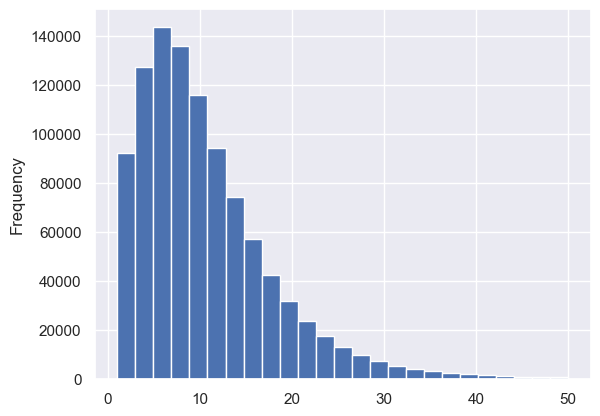

In [8]:
# visualizing string length
length[length <= 50].plot(kind="hist", bins=25)

We can take a snapshot of the biggest outliers (the longest comments) to see if we can gather any information on what they contain.

In [9]:
comments[length > 1000]

5556      DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD ...
75677     Fake news fake news Fake news fake news Fake n...
89444     fuck fuck fuck fuck fuck fuck fuck fuck fuck f...
104339    fuck fuck fuck fuck fuck fuck fuck fuck fuck f...
126164    LIAR Liar liar LIAR Liar liar LIAR Liar liar L...
146938    iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 i...
154696    PATCH NOTES General Gameplay Fixed technology ...
163043    fuck fuck fuck fuck fuck fuck fuck fuck fuck f...
186325    Nvidia GTX 1080 1070 1060 1050 Founders Editio...
217579    Comcast Comcast Comcast Comcast Comcast Comcas...
219087    Raving Raving Raving Raving Raving Raving Ravi...
283846    LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS ...
382449    COMCAST COMCAST COMCAST COMCAST COMCAST COMCAS...
411840    #[MONEY MONEY MONEY MONEY MONEY MONEY MONEY MO...
757452    copy pasta copy pasta copy pasta copy pasta co...
939334    JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERR...
975519    ***a mac is a PC*** ***a mac i

There seems to be a lot of repetition. The same word over and over again, 1000+ times. `copypasta` as one of the commenters blatantly denotes.

Let us also see if at a lower `length` cutoff the same pattern holds true, if all comments longer than 200 words are all copied and pasted.

In [10]:
comments[length > 300]

5556      DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD ...
75677     Fake news fake news Fake news fake news Fake n...
89444     fuck fuck fuck fuck fuck fuck fuck fuck fuck f...
104339    fuck fuck fuck fuck fuck fuck fuck fuck fuck f...
109391    First Lady of the United States First Lady of ...
110522    GENOCIDE GENOCIDE GENOCIDE GENOCIDE GENOCIDE G...
126164    LIAR Liar liar LIAR Liar liar LIAR Liar liar L...
146938    iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 i...
154696    PATCH NOTES General Gameplay Fixed technology ...
163043    fuck fuck fuck fuck fuck fuck fuck fuck fuck f...
164976    First Family TRUMP First Family TRUMP First Fa...
177068    You've got nothing, got nothing, got nothing, ...
186325    Nvidia GTX 1080 1070 1060 1050 Founders Editio...
217579    Comcast Comcast Comcast Comcast Comcast Comcas...
219087    Raving Raving Raving Raving Raving Raving Ravi...
283846    LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS ...
285106    Islam Islam Islam Islam Islam 

The same seems to hold true of all comments longer than 300 words. We can safely drop these comments.

In [11]:
reddit.shape

(1010743, 5)

In [12]:
reddit.drop(reddit[reddit['comment'].str.split().str.len() > 300].index, inplace = True)

In [13]:
reddit.shape

(1010714, 5)

----------------------------------------------------------------------------------------------------------------------------------------------------------

## <a href="#top" id='date'>Dates</a>

The `datetime` data type is a useful tool for EDA, but unfortunately we cannot use it in a model, so it is advised to transform the dates into numeric columns, which can then be processed by our model.

Below we will loop through the `created_utc` column to create lists of `year`, `month`, and `day` respectively, which we will then append to our dataframe.

In [14]:
years_list = [] # instantiating empty lists
months_list = []
days_list = []

# looping through created utc and appending lists
for i in reddit['created_utc']:
    years_list.append(i.year)
    months_list.append(i.month)
    days_list.append(i.day)
    
    

In [15]:
# sanity check
print(f' Lengths: \n Years List: {len(years_list)} \n Months List: {len(months_list)} \n Days List: {len(days_list)}')

 Lengths: 
 Years List: 1010714 
 Months List: 1010714 
 Days List: 1010714


In [16]:
# appending year, month, day columns to dataframe
reddit['year'] = years_list
reddit['month'] = months_list
reddit['day'] = days_list

In [17]:
reddit.head()

,label,comment,subreddit,created_utc,parent_comment,year,month,day
0,0,NC and NH.,politics,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ...",2016,10,16
1,0,You do know west teams play against west teams...,nba,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...,2016,11,1
2,0,"They were underdogs earlier today, but since G...",nfl,2016-09-22 21:45:37,They're favored to win.,2016,9,22
3,0,"This meme isn't funny none of the ""new york ni...",BlackPeopleTwitter,2016-10-18 21:03:47,deadass don't kill my buzz,2016,10,18
4,0,I could use one of those tools.,MaddenUltimateTeam,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...,2016,12,30


Now that we have created `year`, `month` and `day` columns, we can drop the `created_utc` column.

In [18]:
# dropping created_utc
reddit.drop(columns='created_utc', inplace=True)

In [19]:
# sanity check
reddit.head()

,label,comment,subreddit,parent_comment,year,month,day
0,0,NC and NH.,politics,"Yeah, I get that argument. At this point, I'd ...",2016,10,16
1,0,You do know west teams play against west teams...,nba,The blazers and Mavericks (The wests 5 and 6 s...,2016,11,1
2,0,"They were underdogs earlier today, but since G...",nfl,They're favored to win.,2016,9,22
3,0,"This meme isn't funny none of the ""new york ni...",BlackPeopleTwitter,deadass don't kill my buzz,2016,10,18
4,0,I could use one of those tools.,MaddenUltimateTeam,Yep can confirm I saw the tool they use for th...,2016,12,30


    Next we will instantiate variables to represent our `sarcastic` and `non_sarcastic` labels, which we will use to explore the relationships between the remaining columns.

In [20]:
sarcastic = reddit.loc[reddit['label'] == 1]
non_sarcastic = reddit.loc[reddit['label'] == 0]

In [21]:
# confirmation
sarcastic.head()

,label,comment,subreddit,parent_comment,year,month,day
33,1,But they'll have all those reviews!,ProductTesting,"The dumb thing is, they are risking their sell...",2016,11,1
44,1,wow it is totally unreasonable to assume that ...,politics,Clinton campaign accuses FBI of 'blatant doubl...,2016,11,1
45,1,Ho ho ho... But Melania said that there is no ...,politics,Anyone else think that it was interesting the ...,2016,10,18
66,1,I can't wait until @potus starts a twitter war...,politics,Here's what happens when Obama gives up his Tw...,2016,11,1
69,1,gotta love the teachers who give exams on the ...,CFBOffTopic,Monday night Drinking thread Brought to You by...,2016,11,1


In [22]:
# sanity check
non_sarcastic.head()

,label,comment,subreddit,parent_comment,year,month,day
0,0,NC and NH.,politics,"Yeah, I get that argument. At this point, I'd ...",2016,10,16
1,0,You do know west teams play against west teams...,nba,The blazers and Mavericks (The wests 5 and 6 s...,2016,11,1
2,0,"They were underdogs earlier today, but since G...",nfl,They're favored to win.,2016,9,22
3,0,"This meme isn't funny none of the ""new york ni...",BlackPeopleTwitter,deadass don't kill my buzz,2016,10,18
4,0,I could use one of those tools.,MaddenUltimateTeam,Yep can confirm I saw the tool they use for th...,2016,12,30


In [23]:
# verifying sarcastic distribution
round(sarcastic.shape[0] / reddit.shape[0] * 100, 2)

50.0

So far we have maintained our 50/50 split of sarcastic to non sarcastic labels.

----------------------------------------------------------------------------------------------------------------------------------------------------------

We will plot all of the columns associated with date with a side-by-side comparison of sarcastic and non sarcastic.

<Figure size 640x480 with 0 Axes>

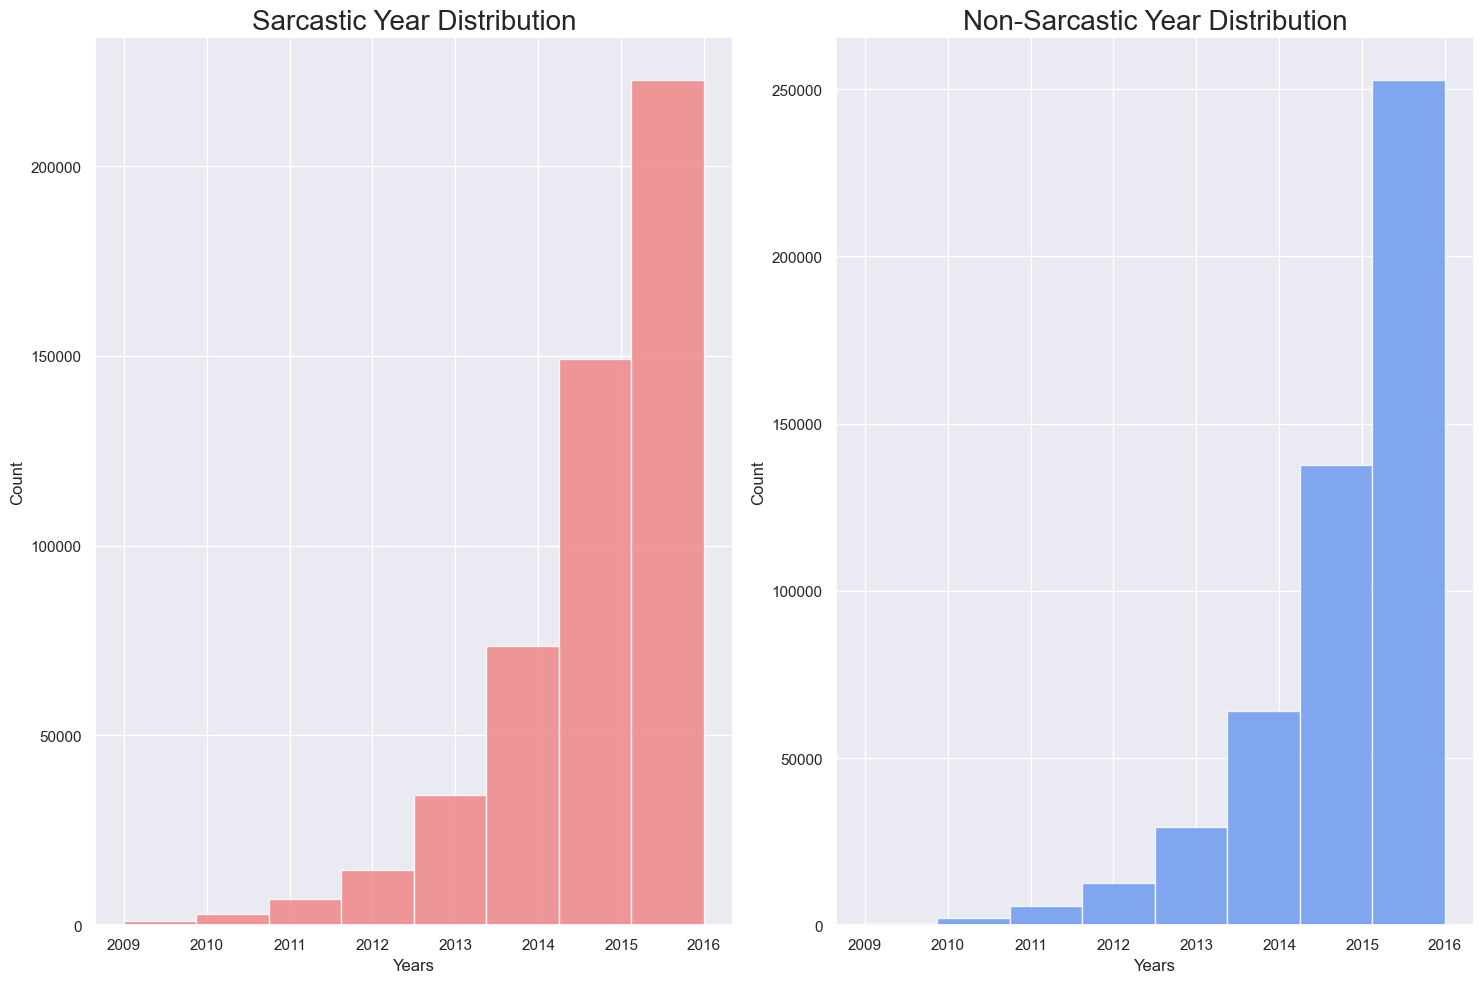

In [24]:
plt.figure()
plt.subplots(1,2, figsize=(15,10))

plt.subplot(1,2,1)
plt.hist(sarcastic['year'], bins=8, color='lightcoral', alpha=0.8)
plt.xlabel('Years')
plt.ylabel('Count')
plt.title('Sarcastic Year Distribution', fontsize=20)

plt.subplot(1,2,2)
plt.hist(non_sarcastic['year'], bins=8, color='cornflowerblue', alpha=0.8)
plt.xlabel('Years')
plt.ylabel('Count')
plt.title('Non-Sarcastic Year Distribution', fontsize=20)

plt.tight_layout()
plt.show()

The distributions look pretty much identical, though there are a bit more non sarcastic comments in 2016.

In [25]:
sarcastic['year'].value_counts()

2016    222761
2015    149290
2014     73505
2013     34193
2012     14592
2011      6944
2010      2977
2009      1078
Name: year, dtype: int64

In [26]:
non_sarcastic['year'].value_counts()

2016    252883
2015    137554
2014     64006
2013     29364
2012     12714
2011      5779
2010      2302
2009       772
Name: year, dtype: int64

Looking at the value counts, we can also see the similarities, though indeed there are slightly more non sarcastic comments in recent years.

    Moving on to the `month` and `day` columns.

<Figure size 640x480 with 0 Axes>

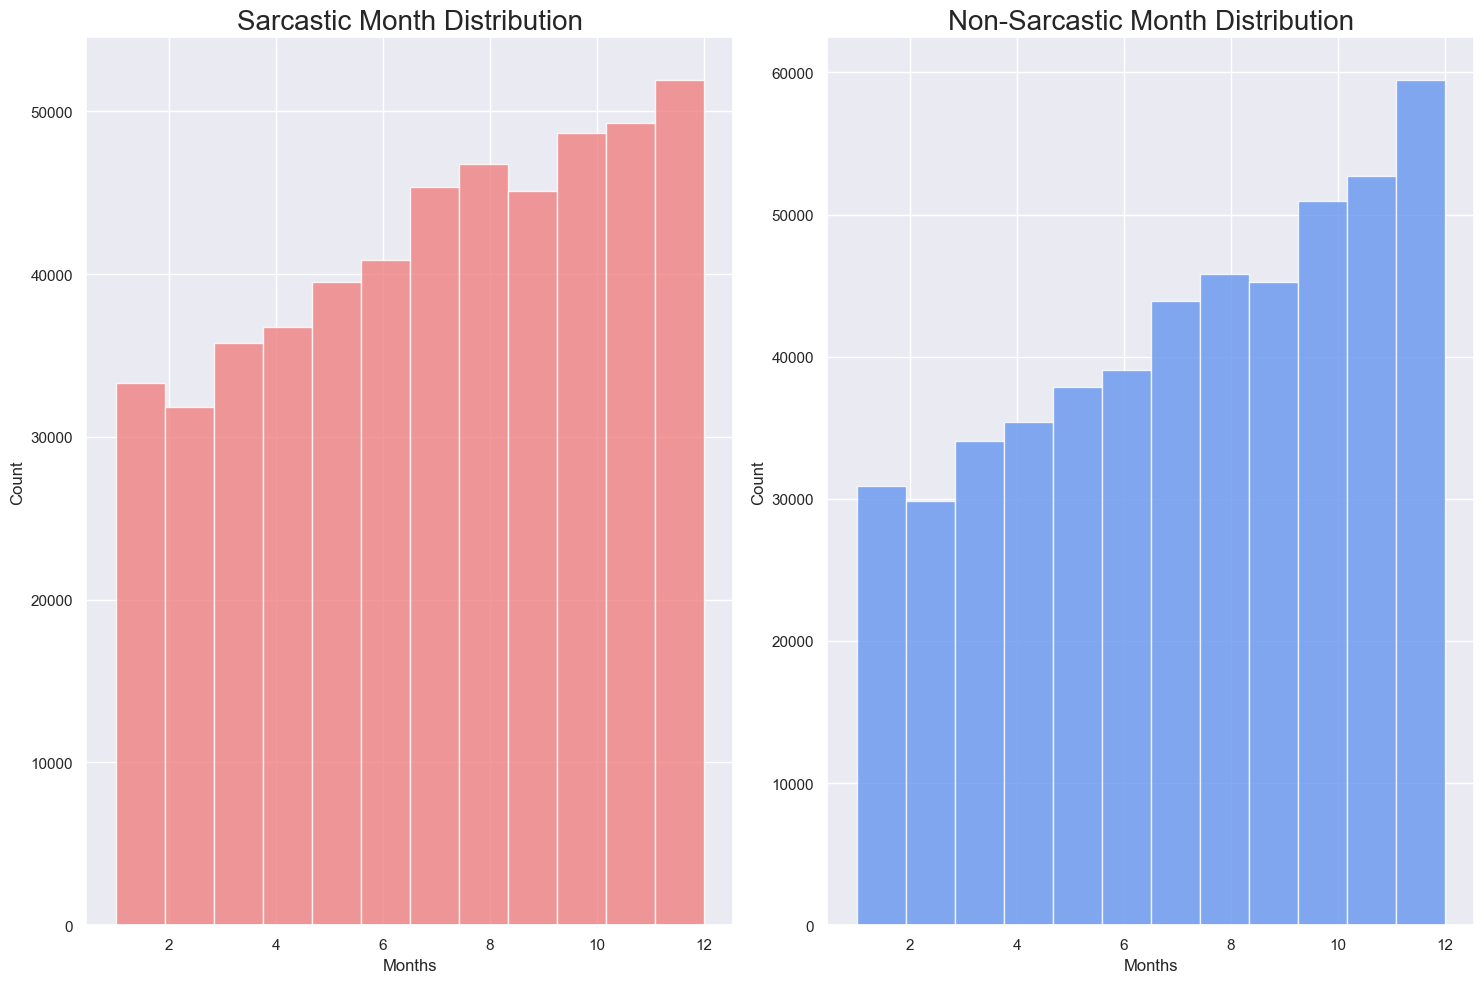

In [27]:
plt.figure()
plt.subplots(1,2, figsize=(15,10))

plt.subplot(1,2,1)
plt.hist(sarcastic['month'], bins=12, color='lightcoral', alpha=0.8)
plt.xlabel('Months')
plt.ylabel('Count')
plt.title('Sarcastic Month Distribution', fontsize=20)

plt.subplot(1,2,2)
plt.hist(non_sarcastic['month'], bins=12, color='cornflowerblue', alpha=0.8)
plt.xlabel('Months')
plt.ylabel('Count')
plt.title('Non-Sarcastic Month Distribution', fontsize=20)

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

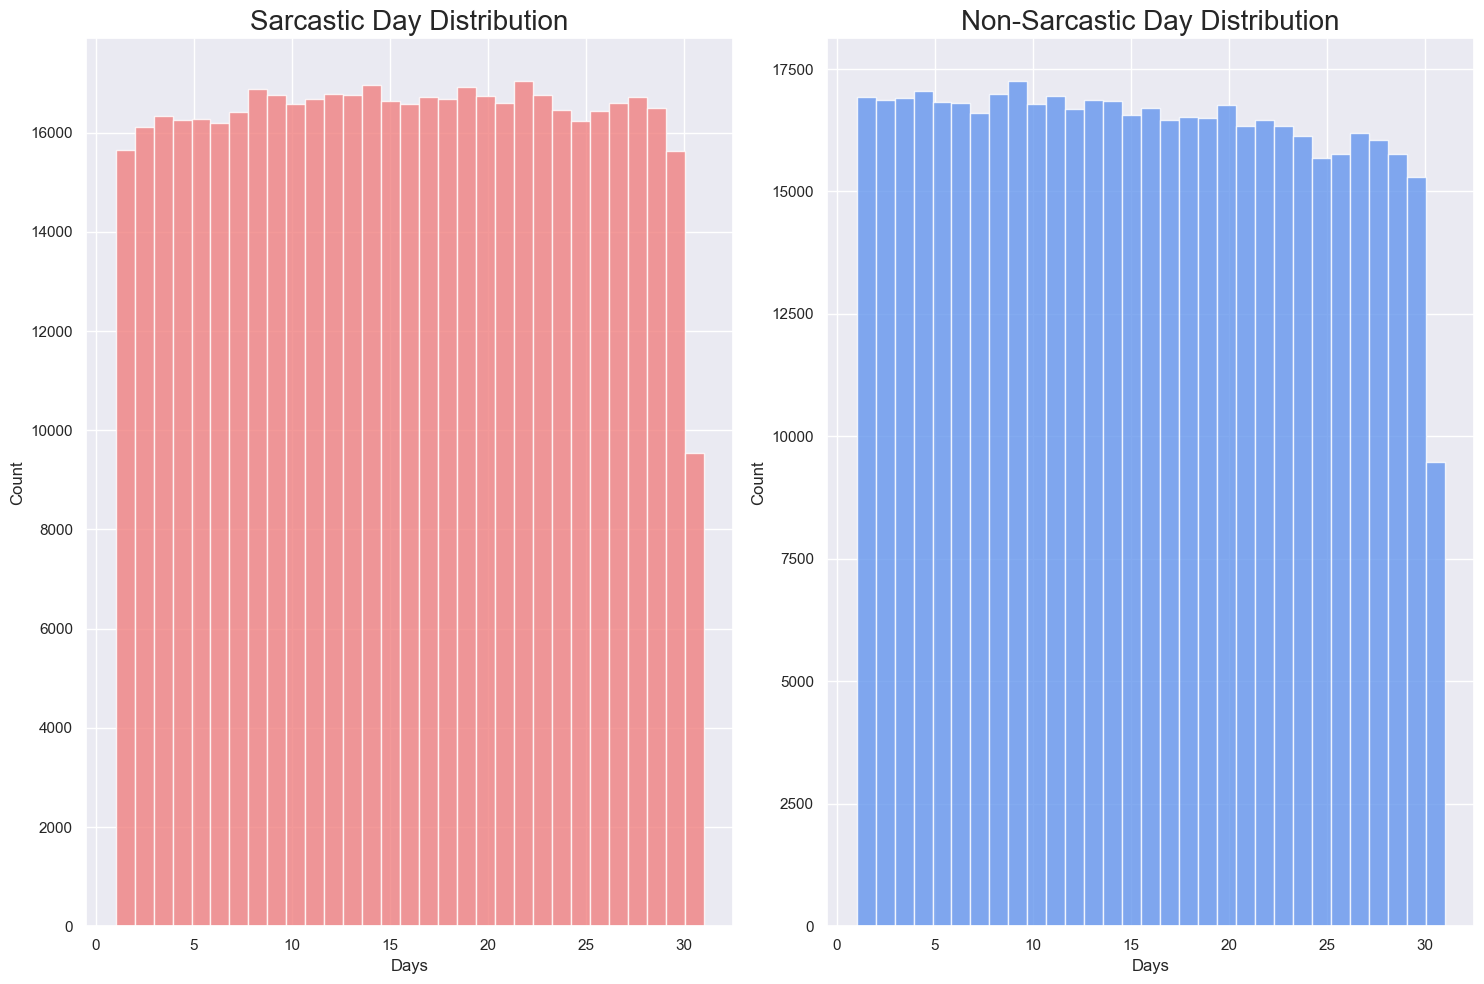

In [28]:
plt.figure()
plt.subplots(1,2, figsize=(15,10))

plt.subplot(1,2,1)
plt.hist(sarcastic['day'], bins=31, color='lightcoral', alpha=0.8)
plt.xlabel('Days')
plt.ylabel('Count')
plt.title('Sarcastic Day Distribution', fontsize=20)

plt.subplot(1,2,2)
plt.hist(non_sarcastic['day'], bins=31, color='cornflowerblue', alpha=0.8)
plt.xlabel('Days')
plt.ylabel('Count')
plt.title('Non-Sarcastic Day Distribution', fontsize=20)

plt.tight_layout()
plt.show()

### Observations:

- all date related columns show extremely similar distributions and identical trends.
- the `year` column shows a steep increase in comments between 2014 and 2015
- the `month` column shows a more gradual increase throughout the year
- and the `day` column is almost entirely flat

Before proceeding any further, let us check the correlation that each `date` column has with our target, `label`.

In [29]:
round(np.corrcoef(reddit['label'], reddit['year'])[0][1],2)

-0.05

In [30]:
round(np.corrcoef(reddit['label'], reddit['month'])[0][1],2)

-0.03

In [31]:
round(np.corrcoef(reddit['label'], reddit['day'])[0][1],2)

0.01

The correlations between the dates and the labels are effectively zero, which is consistent with the eye-test that showed little to no difference in their distributions between labels.

As the dates seem to hold little predictive value, we can go ahead and drop them.

In [64]:
reddit.drop(columns=['year','day', 'month'], inplace=True)

In [65]:
# verification
reddit.head()

,label,comment,author,subreddit,parent_comment
0,0,NC and NH.,Trumpbart,politics,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,Yep can confirm I saw the tool they use for th...


## <a href="#top" id='subs'>Subreddits</a>

In [ ]:
reddit['subreddit'].value_counts()

In [ ]:
(reddit['subreddit'].value_counts() < 2).sum() / reddit['subreddit'].nunique()

In [ ]:
(reddit['subreddit'].value_counts() =< 5).sum() / reddit['subreddit'].nunique()

In [ ]:
reddit.drop(columns='subreddit', inplace=True)

In [ ]:
reddit.head()

In [ ]:
#reddit.to_csv('comment_plus_parent.csv')

In [ ]:
reddit.drop(columns='parent_comment', inplace=True)

In [ ]:
reddit.head()

In [ ]:
reddit.shape[0]

In [ ]:
reddit.shape[0] / 4

In [ ]:
reddit_sample = reddit.sample(252679, random_state=42)

In [ ]:
percent_sarcastic = reddit_sample.loc[reddit_sample['label'] ==1 ].shape[0] / reddit_sample.shape[0] * 100

In [ ]:
reddit_sample.head()

In [ ]:
reddit_sample.to_csv('sample_comments.csv')

In [ ]:
reddit.to_csv('reddit_comments.csv')